In [1]:
import pandas as pd

import numpy as np

import itertools

from datetime import datetime

import time

import pytz
import sys
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

import seaborn as sns

import MetaTrader5 as mt5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# LOAD DATA

In [2]:
sSymbol = "NAT.GAS"
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 10, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2021, 11, 1, tzinfo=gc_o_TIME_ZONE)

In [3]:
aDatesToFetch = list(pd.date_range(start=gc_dt_FROM, end=gc_dt_TO)) #created since MT5 library fails due to time out.
aDatesSampled = aDatesToFetch[::200]
aDatesSampled.append(aDatesToFetch[-1])
aDatesSampled = list(set(aDatesSampled))
aDatesSampled.sort()

dfOhlc = pd.DataFrame()
for i in range(0, len(aDatesSampled) - 1):
    dtFrom = aDatesSampled[i]
    dtTo = aDatesSampled[i+1]

    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()

    dfOhlcSample = mt5.copy_rates_range(
        sSymbol,
        mt5.TIMEFRAME_M30,
        dtFrom, 
        dtTo
    )
    
    if len(dfOhlcSample) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()

    dfOhlcSample = pd.DataFrame(dfOhlcSample)

    dfOhlcSample['timestamp'] = pd.to_datetime(dfOhlcSample['time'], unit= "s")
    dfOhlcSample.set_index('timestamp', inplace=True)
    
    dfOhlc = dfOhlc.append(dfOhlcSample)

In [4]:
dfOhlc["weekday"] = dfOhlc.index.weekday
dfOhlc["hour"] = dfOhlc.index.hour
dfOhlc["minute"] = dfOhlc.index.minute

In [5]:
dfOhlc.drop(["time"], axis = 1 , inplace = True)

# DESCRIBE DATA

In [6]:
dfOhlc

,open,high,low,close,tick_volume,spread,real_volume,weekday,hour,minute
timestamp,,,,,,,,,,
2021-10-01 01:00:00,6.004,6.057,5.998,6.039,446,10,13425000,4,1,0
2021-10-01 01:30:00,6.039,6.048,5.981,5.990,259,10,7849300,4,1,30
2021-10-01 02:00:00,5.990,6.027,5.986,5.997,277,10,8385000,4,2,0
2021-10-01 02:30:00,5.994,5.994,5.945,5.970,295,5,8910000,4,2,30
2021-10-01 03:00:00,5.971,6.021,5.964,5.992,357,15,10760000,4,3,0
...,...,...,...,...,...,...,...,...,...,...
2021-10-29 22:00:00,5.499,5.554,5.490,5.533,1524,13,15225000,4,22,0
2021-10-29 22:30:00,5.533,5.554,5.489,5.548,1334,14,13289000,4,22,30
2021-10-29 23:00:00,5.547,5.582,5.547,5.559,680,10,6746000,4,23,0


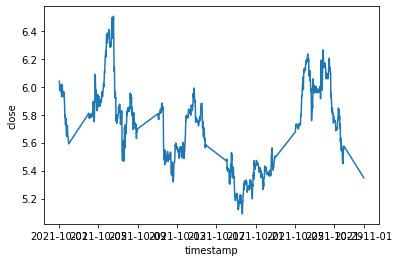

In [7]:
sns.lineplot(data  = dfOhlc["close"])

# PREPROCESSING

In [8]:
sModelName = os.path.join(sSymbol , "__deep learning model__")

## Split Data

In [9]:
fTrainingRatio = 0.6
fValidationRatio = 0.2
fTestRatio = 0.2

ixTrain, ixTest = train_test_split(
    dfOhlc.index,
    test_size=1-fTrainingRatio,
    shuffle=False)

ixValidation, ixTest= train_test_split(
    ixTest,
    test_size=fTestRatio/(fTestRatio + fValidationRatio),
    shuffle=False)

## Scale Data

In [10]:
dfScaledOhlc = pd.DataFrame(index = dfOhlc.index, columns  = dfOhlc.columns)


for sColumn in dfOhlc.columns:
    oScaler = StandardScaler()
    
    dfTrain = pd.DataFrame(dfOhlc.loc[ixTrain, sColumn])
    dfValidation = pd.DataFrame(dfOhlc.loc[ixValidation, sColumn])
    dfTest = pd.DataFrame(dfOhlc.loc[ixTest, sColumn])
    
    oScaler.fit(dfTrain)
    
    dfScaledOhlc.loc[ixTrain, sColumn] = np.reshape(oScaler.transform(dfTrain), (-1))
    dfScaledOhlc.loc[ixValidation, sColumn] = np.reshape(oScaler.transform(dfValidation), (-1))
    dfScaledOhlc.loc[ixTest, sColumn] = np.reshape(oScaler.transform(dfTest), (-1))

    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))

## Feature Engineering

In [11]:
aInputFeatures = ['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume','weekday', 'hour', 'minute']
iBackwardTimeWindow = 8
iNrInputFeatures = len(aInputFeatures)
aBackwardTimeSteps = range(-iBackwardTimeWindow, 0)

tplInputColumns = list(itertools.product(aBackwardTimeSteps, aInputFeatures))
miInputColums = pd.MultiIndex.from_tuples(tplInputColumns, names= ["time_step", "feature"])

dfInput = pd.DataFrame( columns = miInputColums)

for i in aBackwardTimeSteps:
    for sInputFeature in aInputFeatures:
        dfInput.loc[:, (i, sInputFeature)] = dfScaledOhlc[sInputFeature].shift(-i)

In [13]:
aOutputFeatures = ['close']
iForwardTimeWindow  =  8
iNrOutputFeatures = len(aOutputFeatures)
aForwardTimeSteps = range(0, iForwardTimeWindow)

tplOutputColumns = list(itertools.product(aForwardTimeSteps, aOutputFeatures))
ixOutputColums = pd.MultiIndex.from_tuples(tplOutputColumns, names= ["time_step", "feature"])

dfOutput = pd.DataFrame(columns = ixOutputColums)

for i in aForwardTimeSteps:
    for sOutputFeature in aOutputFeatures:
        dfOutput.loc[:, (i, sOutputFeature)] = dfScaledOhlc[sOutputFeature].shift(-i)

In [14]:
dfMerged = dfInput.join(dfOutput, how= "inner")
dfMerged.dropna(inplace=True)
dfInput = dfMerged[dfInput.columns]
dfOutput = dfMerged[dfOutput.columns]
ixTrain = ixTrain.join(dfMerged.index, how = "inner")
ixValidation = ixValidation.join(dfMerged.index, how = "inner")
ixTest = ixTest.join(dfMerged.index, how = "inner")

In [15]:
dfInputTrain = dfInput.loc[ixTrain]
aInputTrain = np.reshape(dfInputTrain.values, (dfInputTrain.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputValidation = dfInput.loc[ixValidation]
aInputValidation = np.reshape(dfInputValidation.values, (dfInputValidation.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputTest = dfInput.loc[ixTest]
aInputTest = np.reshape(dfInputTest.values, (dfInputTest.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfOutputTrain = dfOutput.loc[ixTrain]
aOutputTrain = np.reshape(dfOutputTrain.values, (dfOutputTrain.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputValidation = dfOutput.loc[ixValidation]
aOutputValidation = np.reshape(dfOutputValidation.values, (dfOutputValidation.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputTest = dfOutput.loc[ixTest]
aOutputTest = np.reshape(dfOutputTest.values, (dfOutputTest.shape[0], iForwardTimeWindow, iNrOutputFeatures))

In [16]:
aInputTrain = np.asarray(aInputTrain, np.float32)
aInputValidation = np.asarray(aInputValidation, np.float32)
aInputTest = np.asarray(aInputTest, np.float32)
aOutputTrain = np.asarray(aOutputTrain, np.float32)
aOutputValidation = np.asarray(aOutputValidation, np.float32)
aOutputTest = np.asarray(aOutputTest, np.float32)

## Train

### Set Hyperparameters

In [17]:
iBatchSize = 64
iEpochSize = 10000
iNrOfHiddenNeurons = 32

oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)

fncLoss =  tf.keras.losses.MeanSquaredError()

oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)

### Build Model

In [18]:
aEncoderInputs = keras.Input(
    shape=(iBackwardTimeWindow, iNrInputFeatures), 
    name="aEncoderInputs")

aEncoderHiddens, aFinalH, aFinalC = LSTM(iNrOfHiddenNeurons,
                                         return_state = True, 
                                         return_sequences = True,
                                         activation = keras.activations.linear
                                        )(aEncoderInputs)
aFinalH = keras.layers.BatchNormalization(momentum=0.6)(aFinalH)
aFinalC = keras.layers.BatchNormalization(momentum=0.6)(aFinalC)

aDecoderInputs = keras.layers.RepeatVector(iForwardTimeWindow)(aFinalH)

aDecoderHiddens = LSTM(iNrOfHiddenNeurons, 
                       return_state = False, 
                       return_sequences = True,
                       activation = keras.activations.linear
                      )(aDecoderInputs, initial_state=[aFinalH, aFinalC])

aAttentions = keras.layers.dot([aDecoderHiddens, aEncoderHiddens], axes=[2, 2])
aAttentions = keras.layers.Activation('softmax')(aAttentions)

aContextVector = keras.layers.dot([aAttentions, aEncoderHiddens], axes=[2,1])
aContextVector = keras.layers.BatchNormalization(momentum=0.6)(aContextVector)
aContextVector = keras.layers.concatenate([aContextVector, aDecoderHiddens])

aDecoderOutputs = keras.layers.TimeDistributed(
    Dense(iNrOutputFeatures)
)(aContextVector)

oPredictiveModel = keras.Model(
    inputs=aEncoderInputs,
    outputs=aDecoderOutputs
)

### Compile Model

In [19]:
oFnLoss =  tf.keras.losses.MeanSquaredError()
oPredictiveModel.compile(optimizer=oOptimizer,
                         loss = oFnLoss
                        )

### Fit Model

In [20]:
oPredictiveModel.fit(
    aInputTrain, 
    aOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (aInputValidation, aOutputValidation),
    validation_batch_size= iBatchSize,
    callbacks=[oEarlyStop]
)

Epoch 1/10000
9/9 [==============================] - 9s 129ms/step - loss: 3.9101 - val_loss: 6.7279
Epoch 2/10000
9/9 [==============================] - 0s 46ms/step - loss: 3.8129 - val_loss: 8.1369
Epoch 3/10000
9/9 [==============================] - 0s 50ms/step - loss: 3.6978 - val_loss: 8.2382
Epoch 4/10000
9/9 [==============================] - 0s 49ms/step - loss: 3.5679 - val_loss: 7.7255
Epoch 5/10000
9/9 [==============================] - 0s 49ms/step - loss: 3.5221 - val_loss: 7.0982
Epoch 6/10000
9/9 [==============================] - 0s 46ms/step - loss: 3.4437 - val_loss: 7.3644
Epoch 7/10000
9/9 [==============================] - 0s 48ms/step - loss: 3.3796 - val_loss: 7.5103
Epoch 8/10000
9/9 [==============================] - 0s 47ms/step - loss: 3.3109 - val_loss: 7.8543
Epoch 9/10000
9/9 [==============================] - 0s 53ms/step - loss: 3.2014 - val_loss: 7.2790
Epoch 10/10000
9/9 [==============================] - 0s 45ms/step - loss: 3.1285 - val_loss: 6.674

9/9 [==============================] - 0s 48ms/step - loss: 0.5239 - val_loss: 1.7898
Epoch 83/10000
9/9 [==============================] - 0s 47ms/step - loss: 0.5062 - val_loss: 1.5486
Epoch 84/10000
9/9 [==============================] - 0s 48ms/step - loss: 0.5108 - val_loss: 1.4448
Epoch 85/10000
9/9 [==============================] - 0s 49ms/step - loss: 0.4878 - val_loss: 1.6365
Epoch 86/10000
9/9 [==============================] - 0s 48ms/step - loss: 0.5039 - val_loss: 1.4087
Epoch 87/10000
9/9 [==============================] - 0s 51ms/step - loss: 0.4916 - val_loss: 1.5296
Epoch 88/10000
9/9 [==============================] - 0s 47ms/step - loss: 0.4825 - val_loss: 1.6462
Epoch 89/10000
9/9 [==============================] - 0s 51ms/step - loss: 0.4519 - val_loss: 1.4083
Epoch 90/10000
9/9 [==============================] - 0s 53ms/step - loss: 0.4602 - val_loss: 1.5406
Epoch 91/10000
9/9 [==============================] - 0s 50ms/step - loss: 0.4401 - val_loss: 1.5009
Epoch

### Save Model

In [21]:
oPredictiveModel.save_weights(sModelName)

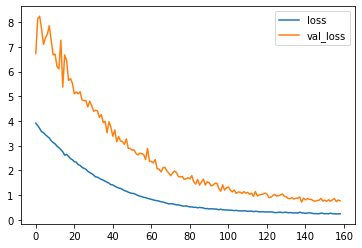

In [22]:
pd.DataFrame(oPredictiveModel.history.history).plot()

## Test

In [23]:
oPredictiveModel.load_weights(sModelName)

aPrediction = oPredictiveModel.predict(aInputTest)
aPrediction = aPrediction.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfPrediction = pd.DataFrame(aPrediction, index = ixTest, columns = ixOutputColums)

aActual = aOutputTest.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfActual =  pd.DataFrame(aActual, index = ixTest, columns = ixOutputColums)

for sOutputFeature in aOutputFeatures:
    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sOutputFeature + ".sav")
    oScaler = pickle.load(open(sScalerFilePath, 'rb'))
    
    tplMaskFeature = (slice(None), slice(sOutputFeature))
    
    dfPrediction.loc[:,tplMaskFeature] = oScaler.inverse_transform(dfPrediction.loc[:, tplMaskFeature])
    dfActual.loc[:, tplMaskFeature] =  oScaler.inverse_transform(dfActual.loc[:, tplMaskFeature])

# RESULTS

In [24]:
iComparisionTimeStep = 1
iFrom = 15 * iForwardTimeWindow
iTo = iFrom + iForwardTimeWindow

In [25]:
y_pred = dfPrediction.iloc[:, iComparisionTimeStep]
y_true = dfActual.iloc[:, iComparisionTimeStep]
aMetrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                0.181
       mean squared error:                0.042
                max error:                0.424
                 r2 score:               -0.181


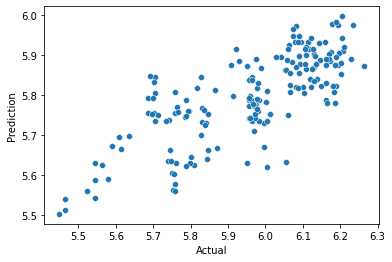

In [26]:
dfTestComparision = pd.DataFrame(dfPrediction.iloc[:,iComparisionTimeStep])
dfTestComparision = dfTestComparision.join(dfActual.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")

-43.192993945734074


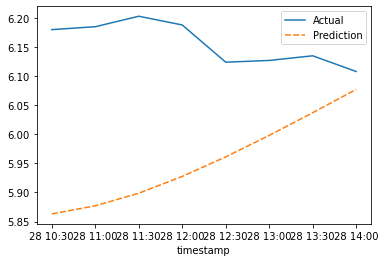

In [27]:
dfStepComparision = dfActual.iloc[iFrom:iTo].loc[:, (slice(None), slice(sOutputFeature))].loc[:, 0]
dfStepComparision.columns = ["Actual"]

dfStepComparision["Prediction"] = dfPrediction.iloc[iFrom].loc[:, aOutputFeatures].values

print(r2_score(dfStepComparision["Actual"], dfStepComparision["Prediction"]))
sns.lineplot(data = dfStepComparision)

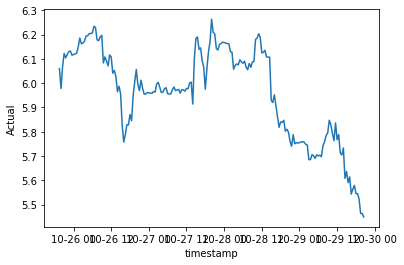

In [28]:
sns.lineplot(data = dfTestComparision["Actual"])

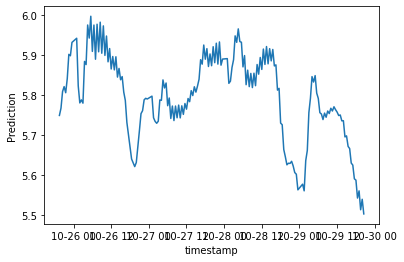

In [29]:
sns.lineplot(data = dfTestComparision["Prediction"])

# REFERENCES

https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/

https://towardsdatascience.com/customize-loss-function-to-make-lstm-model-more-applicable-in-stock-price-prediction-b1c50e50b16c

https://keras.io/getting_started/faq/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://www.tensorflow.org/tutorials/structured_data/time_series

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60

https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb